Find out what makes the method tick or not tick, and under what settings it can fail. Specifically,

1. What sort of distributions can we correct with a poor low-fidelity model? Specifically, how does the number of corrected particles affect the stein discrepancy score, MMD or other measures?

2. When does the low-fidelity model completely dominate the high-fidelity one? What features of the correction guide the samples?

3. What is the effect of adding even more models to the correction?

In [31]:
import os
import re
import numpy as np
import torch
import torch.distributions as tdst
import scipy
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.stats import multivariate_normal
from scipy.stats import qmc
import numpy.matlib as nm

from mxmc import Optimizer

from rich.progress import track

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-v0_8-notebook')
plt.rc("font", family="serif")
plt.rc("axes.spines", top=True, right=True)
# set explicit fontsizes for ticks, lables, legend and title
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14, edgecolor="none", frameon=True)
plt.rc('figure', titlesize=16)

# add faint gridlines to rc settings (change grid alpha and grid linestyle )
# set grid to always be on
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'


marker_symbol = u'\u2B2C'

In [19]:
mu_oracle_hf = np.array([0.5, 0.2])
cov_oracle_hf = np.array([[2.0, 0.3], [0.3, 0.5]])

mu_oracle_lf1 = np.array([-2.5, -1.5])
cov_oracle_lf1 = np.array([[1.5, 0.0], [0.0, 0.5]])

In [20]:
def autodiff_log_prob(log_prob_fn):
    """
    Wraps a log probability function to return both the (log_prob, grad_log_prob).
    log_prob_fn: Return the log probability for a tensor input.
    """
    def wrapped(theta):
        theta =  torch.as_tensor(theta, dtype=torch.float32).clone().detach().requires_grad_(True)
        log_prob = log_prob_fn(theta)
        grad_log_prob = torch.autograd.grad(log_prob.sum(), theta)[0]
        return grad_log_prob.detach().numpy()
    
    return wrapped

In [21]:
def mvn_dlnprob_hf(theta, mu, cov):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

def mvn_dlnprob_lf(theta, mu, cov):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

In [22]:
def lnprob0_gaussian(theta):
    dist_gaussian = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_hf), 
                                            torch.from_numpy(cov_oracle_hf)
                                           )
    
    return dist_gaussian.log_prob(theta)

def lnprob1_gaussian(theta):
    dist_gaussian = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_lf1), 
                                            torch.from_numpy(cov_oracle_lf1)
                                           )
    
    return dist_gaussian.log_prob(theta)

In [83]:
def lnprobmix_gaussian(theta, w=0.5):
    """
    Log-density of a mixture of two Gaussians:
      p(theta) = w * N(theta; mu0, cov0) + (1-w) * N(theta; mu1, cov1)

    theta: Tensor of shape (..., D)
    w: mixing weight for the first component
    """
    dist0 = tdst.MultivariateNormal(
        torch.from_numpy(mu_oracle_hf),
        torch.from_numpy(cov_oracle_hf)
    )
    lp0 = dist0.log_prob(theta)
    dist1 = tdst.MultivariateNormal(
        torch.from_numpy(mu_oracle_lf1),
        torch.from_numpy(cov_oracle_lf1)
    )
    lp1 = dist1.log_prob(theta)

    mix_logits = torch.stack([lp0 + torch.log(torch.tensor(w)),
                              lp1 + torch.log(torch.tensor(1.0 - w))],
                             dim=-1)
    return torch.logsumexp(mix_logits, dim=-1)

**Case: Particles to be corrected are randomized for every SVGD iteration**

In [70]:
class BifidelitySVGDSingleSetRandomized():
    """
    A single subset of particles takes both hifi and lofi evaluations. Correction particles are randomized every iteration.
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, theta2=None, h = -1):
        if theta2 is None:
            sq_dist = pdist(theta)
            pairwise_dists = squareform(sq_dist)**2
            if h < 0: # if h < 0, using median trick
                h = np.median(pairwise_dists)
                h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))
        else:
            sq_dist = pdist(np.vstack((theta, theta2)))
            pairwise_dists = squareform(sq_dist)**2
            if h < 0:
                h = np.median(pairwise_dists)
                h = np.sqrt(0.5 * h / np.log(theta.shape[0] + theta2.shape[0] + 1))
                

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        if theta2 is None:
            dxkxy = -np.matmul(Kxy, theta)
            sumkxy = np.sum(Kxy, axis=1)
            for i in range(theta.shape[1]):
                dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
            dxkxy = dxkxy / (h**2)
            return (Kxy, dxkxy, h)

        else:
            return Kxy
    
    def mmd2(self, X, Y):
        """
        Compute the (biased) MMD^2 between samples X and Y with an RBF kernel.
        """
        n, m = X.shape[0], Y.shape[0]

        K_xx, _, _ = self.svgd_kernel(X)
        K_yy, _, _ = self.svgd_kernel(Y)
        K_xy = self.svgd_kernel(X, theta2 = Y)
        mmd_sq = ((K_xx.sum() - np.trace(K_xx))/ (n*(n - 1))
              + (K_yy.sum() - np.trace(K_yy)) / (m*(m - 1))
              - 2.0 * K_xy.sum() / (n*m))  - np.trace(K_yy)
        return mmd_sq

    
    def update(self, x0, lnprob_1, lnprob_0,
               n_correct_idx_all,
               n_iter = 1000,
               stepsize = 5e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False,
               hf_oracle_samps=None):
        
        
        if x0 is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter + 1))
        lengthscales_all = np.zeros(n_iter)
        #         disc_all = np.zeros(n_iter + 1)

        
        theta_all[:, :, 0] = x0
        #         disc_all[0] = self.mmd2(hf_oracle_samps, theta_all[:, :, 0])
        
        
        fudge_factor = 1e-6
        historical_grad = 0

        for itn in track(range(1, n_iter + 1), description="Running iterations for particle position updates..."):
            #             print('iter ' + str(itn))

            if itn !=0:
                theta_lf = theta_all[:, :, itn - 1]
                theta_hf = theta_all[n_correct_idx_all[:, itn - 1], :, itn - 1]
                
            lnpgrad_1 = lnprob_1(theta_lf)
            lnpgrad_0 = lnprob_0(theta_hf)
            
            kxy1, dxkxy1, h1 = self.svgd_kernel(theta_lf, h=-1)
            kxy0, dxkxy0, h0 = self.svgd_kernel(theta_hf, h=-1)
            
            
            grad_theta = (np.matmul(kxy1, lnpgrad_1) + dxkxy1) / x0.shape[0]
            lengthscales_all[itn - 1] = h1
            
            grad_theta_correction = np.matmul(kxy1[:, n_correct_idx_all[:, itn - 1]], 
                                              (lnpgrad_0 - lnpgrad_1[n_correct_idx_all[:, itn - 1], :])) / theta_hf.shape[0]
            grad_theta = grad_theta + grad_theta_correction

            # adagrad
            if itn == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            
            #             theta = theta + stepsize * adj_grad
            theta_all[:, :, itn] = theta_all[:, :, itn - 1] + stepsize * adj_grad
            #             disc_all[itn] = self.mmd2(hf_oracle_samps, theta_all[:, :, itn])
            

        return theta_all, lengthscales_all

In [85]:
n_correct = 50
N_PARTICLES = 512
torch.manual_seed(2025)

hf_oracle_dist = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_hf), 
                                            torch.from_numpy(cov_oracle_hf)
                                           )

hf_oracle_samps = hf_oracle_dist.sample((N_PARTICLES,)).detach().numpy()

# initial_particles = torch.normal(0.0, 1.0, size=(N_PARTICLES, 2))
sampler = qmc.Sobol(d=2, scramble=False)
initial_particles = sampler.random(n=N_PARTICLES)

# # rescale initial points to lie within -1, 1
# initial_particles = 2 * initial_particles - 1
initial_particles = initial_particles - 1.5

n_correct_idx = np.random.choice(N_PARTICLES, n_correct)

lnprob_1 = autodiff_log_prob(lnprob1_gaussian)
# lnprob_0 = autodiff_log_prob(lnprob0_gaussian)
lnprob_0 = autodiff_log_prob(lnprobmix_gaussian)

In [86]:
svgd_bifidelity_rd = BifidelitySVGDSingleSetRandomized()
n_correct_rd = 25
n_correct_idx_all = np.stack([np.random.choice(N_PARTICLES, n_correct_rd) for _ in range(1001)]).T

theta_all_rd, lengthscales_all_rd = svgd_bifidelity_rd.update(initial_particles,
                                             lnprob_1,
                                             lnprob_0,
                                             n_correct_idx_all,
                                             n_iter=1000,
                                             stepsize=0.1,
                                             hf_oracle_samps = hf_oracle_samps
                                             )

Output()

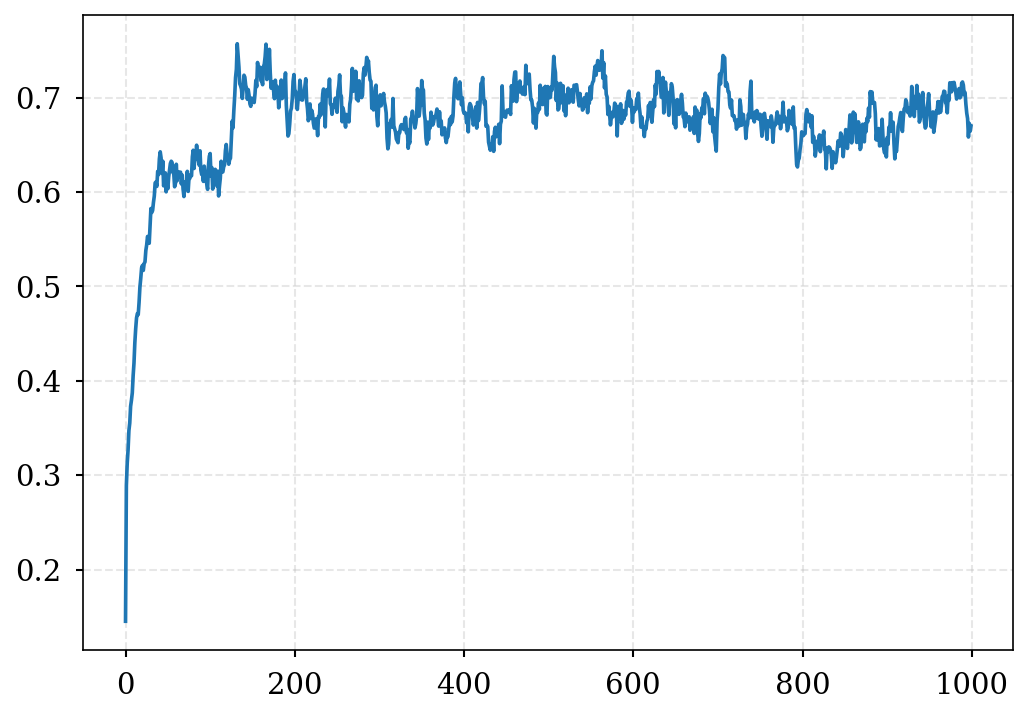

In [89]:
plt.plot(lengthscales_all_rd)

(-4.0, 4.0)

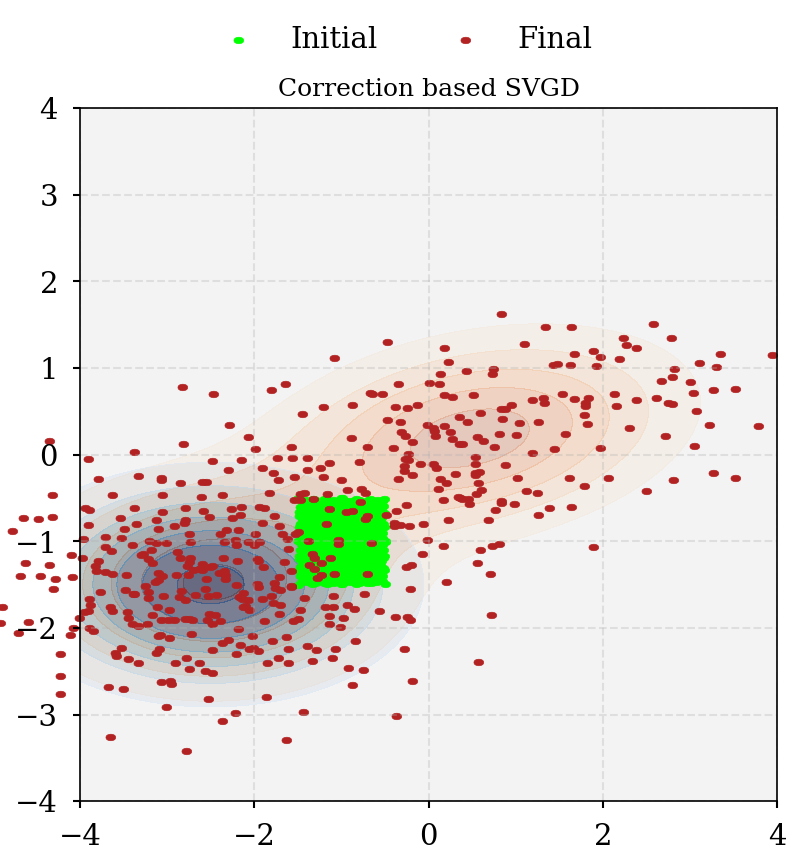

In [88]:
w = 0.5
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_oracle_hf, cov_oracle_hf)
rv_lf = multivariate_normal(mu_oracle_lf1, cov_oracle_lf1)

rv_mix = w * rv_hf.pdf(pos) + (1 - w) * rv_lf.pdf(pos)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.contourf(x, y,
#              rv_hf.pdf(pos),
            rv_mix,
             alpha=0.5,
             cmap='Oranges')

ax.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')


# Scatter initial and final particles
ax.scatter(theta_all_rd[:, 0, 0], theta_all_rd[:, 1, 0],
            color="lime",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Initial")


ax.scatter(theta_all_rd[:, 0, -1], theta_all_rd[:, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Final")


fig.legend(loc="upper center", ncol=2,)
ax.set_title("Correction based SVGD")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

In [7]:
# import gif
# from random import randint
# from matplotlib import pyplot as plt
# gif.options.matplotlib["dpi"] = 200

# @gif.frame
# def plot_svgd_particle_contours(itn):
#     fig = plt.figure(figsize=(6, 6))
#     ax = fig.add_subplot(111)
#     ax.contourf(x, y,
#                  rv_hf.pdf(pos),
#                  alpha=0.5,
#                  cmap='Oranges')

#     ax.contourf(x, y,
#                 rv_lf.pdf(pos),
#                 alpha=0.5,
#                 cmap='Blues')

#     ax.scatter(theta_all_rd[:, 0, itn], theta_all_rd[:, 1, itn],
#                 color="firebrick",
#                 marker="$%s$" % marker_symbol,
#                 s=25,
#                 clip_on=False,
#                 label="")
    
#     ax.set_title("Itn {}".format(itn))


#     ax.scatter(theta_all_rd[n_correct_idx_all[:, itn], 0, itn], theta_all_rd[n_correct_idx_all[:, itn], 1, itn],
#                 color="royalblue",
#                 marker="$%s$" % marker_symbol,
#                 s=25,
#                 clip_on=False,
#                 label="")
    
#     ax.set_xlim((-4, 4))
#     ax.set_ylim((-4, 4))

    
# frames_all = [plot_svgd_particle_contours(i) for i in range(0, 1001, 20)]
# gif.save(frames_all, 'svgd_randomized.gif', duration=0.5)

In [90]:
# lnprob2_gaussian(torch.Tensor(initial_particles)).shape

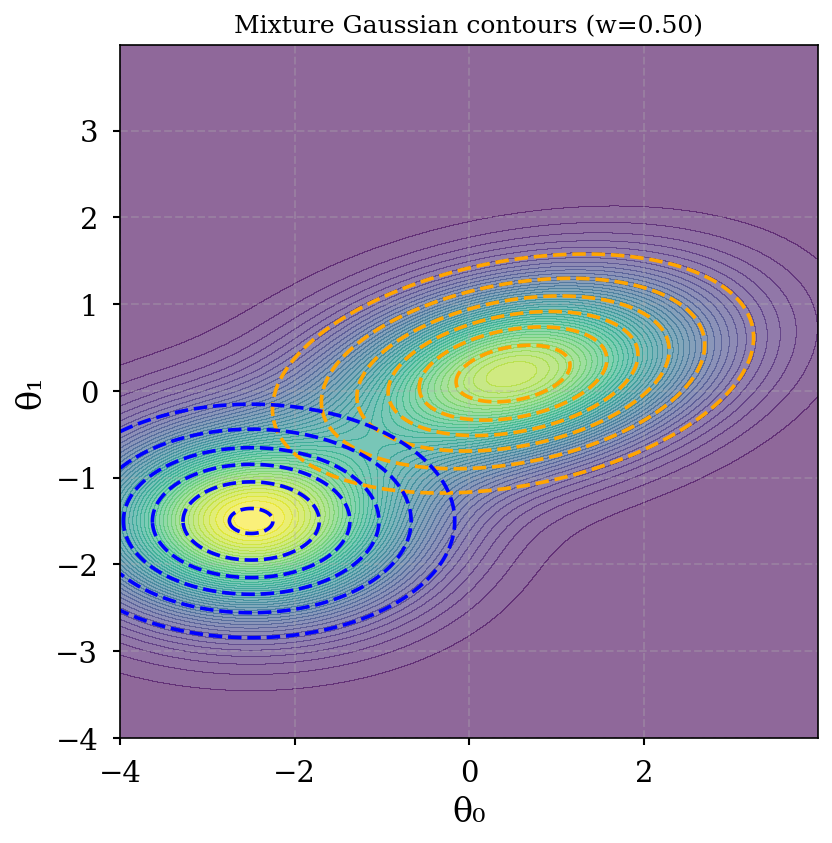

In [91]:
w = 0.5
pdf_mix = w * rv_hf.pdf(pos) + (1 - w) * rv_lf.pdf(pos)

fig, ax = plt.subplots(figsize=(6,6))
# filled contours of mixture
ax.contourf(x, y, pdf_mix, levels=50, alpha=0.6, cmap='viridis')

# # optionally overlay the individual components
ax.contour(x, y, rv_hf.pdf(pos), levels=6, colors='orange', linestyles='--')
ax.contour(x, y, rv_lf.pdf(pos), levels=6, colors='blue',   linestyles='--')

ax.set_xlabel('θ₀')
ax.set_ylabel('θ₁')
ax.set_title(f'Mixture Gaussian contours (w={w:.2f})')
plt.show()